# Making Capital Bikeshare system data usable

## Unzipping files

We'll add all of the files into a new folder (`/unzippedData`)

**Warning**: requires at least 5.63GB of space

In [1]:
import os
import zipfile

from numpy.f2py.auxfuncs import throw_error

for file in os.listdir("./capitalBikeshareData"):
    filepath = "./capitalBikeshareData/" + file
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall("./unzippedData")

## Analysing data before any further data preparation

Since we want to work on as much data as possible, we want to combine the data into one csv file. This however requires the csv files to be the same for the most part. The most important part is for each of the csv files to each have similar/same features. Let's check that.

In [2]:
import os
import pandas as pd

columnNamesDict = dict()
for file in os.listdir("./unzippedData"):
    filepath = "./unzippedData/" + file
    if not os.path.isfile(filepath):
        continue
    fileDataframe = pd.read_csv(filepath, low_memory=False)
    columnNames = ""
    for name in fileDataframe.columns:
        columnNames += name + ", "
    columnNames = columnNames[:-2]
    if columnNames not in columnNamesDict:
        print(filepath)
        print(columnNames + "\n")
        columnNamesDict[columnNames] = fileDataframe.columns.values.tolist()


./unzippedData/2010-capitalbikeshare-tripdata.csv
Duration, Start date, End date, Start station number, Start station, End station number, End station, Bike number, Member type

./unzippedData/202004-capitalbikeshare-tripdata.csv
ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual



Csv files before April 2020 have columns `Duration`, `Start date`, `End date`, `Start station number`, `Start station`, `End station number`, `End station`, `Bike number`, `Member type`.

Csv files after April 2020 have columns `ride_id`, `rideable_type`, `started_at`, `ended_at`, `start_station_name`, `start_station_id`, `end_station_name`, `end_station_id`, `start_lat`, `start_lng`, `end_lat`, `end_lng`, `member_casual`.

We can see that Capital Bikeshare decided to implement coordinates into their data alongside stations. This likely comes from the fact that you can leave your bike or rent a bike in locations that don't classify under a station, which requires assigning a longitude and latitude value.

These factors make combining datasets difficult.


## Combining data into single files based on features

Since we have two different sets of column names / features for two different time ranges, we'll try to make one csv file for both sets.

**Warning**: takes a long time (~8 minutes) and requires at least 5.63 GB of space

In [3]:
import os
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

combinedDataBeforeApril2020 = pd.DataFrame(
    {'Duration': [], 'Start date': [], 'End date': [], 'Start station number': [],
     'Start station': [], 'End station number': [], 'End station': [], 'Bike number': [],
     'Member type': []})

combinedDataAfterApril2020 = pd.DataFrame({'ride_id': [], 'rideable_type': [], 'started_at': [], 'ended_at': [],
                                           'start_station_name': [],
                                           'start_station_id': [], 'end_station_name': [], 'end_station_id': [],
                                           'start_lat': [],
                                           'start_lng': [],
                                           'end_lat': [], 'end_lng': [], 'member_casual': []})

columnNamesDict = set()
for file in os.listdir("./unzippedData"):
    filepath = "./unzippedData/" + file

    if not os.path.isfile(filepath):
        continue

    fileDataframe = pd.read_csv(filepath, low_memory=False,
                                dtype="string")  # String type is important to not convert integers into floats (becomes a problem by adding .0 to the end of an integer)

    if fileDataframe.columns[0] == 'ride_id':
        combinedDataAfterApril2020 = pd.concat([combinedDataAfterApril2020, fileDataframe], ignore_index=True)
    else:
        combinedDataBeforeApril2020 = pd.concat([combinedDataBeforeApril2020, fileDataframe], ignore_index=True)

combinedDataAfterApril2020.to_csv('./combinedDataAfterApril2020.csv')

combinedDataBeforeApril2020.to_csv('./combinedDataBeforeApril2020.csv')

## Assembling a combined csv file based on common features

Since the features after April 2020 are named better, we'll try to use their names.

**Warning**: takes a long time and requires at least 5.63 GB of space

In [1]:
import pandas as pd


# Function for assigning correct datatypes
def set_data_types_combined(dataframe):
    dataframe['started_at'] = pd.to_datetime(dataframe['started_at'], format='ISO8601')
    dataframe['ended_at'] = pd.to_datetime(dataframe['started_at'], format='ISO8601')
    dataframe.astype({"is_member": "bool"})


trimmedDataAfterApril2020 = pd.read_csv('./combinedDataAfterApril2020.csv', index_col=0,
                                        dtype={"Start station number": "string", "End station number": "string"},
                                        low_memory=False)
trimmedDataAfterApril2020.drop(columns=["ride_id", "rideable_type", "start_lat", "end_lat", "start_lng", "end_lng"],
                               axis=1, inplace=True)
trimmedDataAfterApril2020.columns = ["started_at", "ended_at", "start_station_name", "start_station_id",
                                     "end_station_name", "end_station_id", "is_member"]
trimmedDataAfterApril2020.loc[trimmedDataAfterApril2020['is_member'] == "member", 'is_member'] = True
trimmedDataAfterApril2020.loc[trimmedDataAfterApril2020['is_member'] == "casual", 'is_member'] = False

trimmedDataBeforeApril2020 = pd.read_csv('./combinedDataBeforeApril2020.csv', index_col=0,
                                         dtype={"start_station_id": "string", "end_station_id": "string"},
                                         low_memory=False)
trimmedDataBeforeApril2020.drop(columns=["Duration", "Bike number"], axis=1, inplace=True)
trimmedDataBeforeApril2020.columns = ["started_at", "ended_at", "start_station_id", "start_station_name",
                                      "end_station_id", "end_station_name", "is_member"]
trimmedDataBeforeApril2020.loc[trimmedDataBeforeApril2020['is_member'] == "Member", 'is_member'] = True
trimmedDataBeforeApril2020.loc[trimmedDataBeforeApril2020['is_member'] == "Casual", 'is_member'] = False

combinedData = pd.concat([trimmedDataAfterApril2020, trimmedDataBeforeApril2020], ignore_index=True)
set_data_types_combined(combinedData)
combinedData.to_csv('./combinedData.csv')

# In-depth analysis

## Analysing data in greater detail

Now that we have multiple large datasets, we can do further investigation into how good our data is.

Things that we'll check in no particular order:
- Checking if station IDs always go together with the same name
- Checking the amount of empty fields

In [6]:
# Loading in data if required, takes a long time
import pandas as pd

#combinedData = pd.read_csv('./combinedData.csv', index_col=0, type={"start_station_id": "string", "end_station_id": "string"})  # low_memory=False if reading with pandas
combinedDataAfterApril2020 = pd.read_csv('./combinedDataAfterApril2020.csv', low_memory=False)
combinedDataBeforeApril2020 = pd.read_csv('./combinedDataBeforeApril2020.csv', low_memory=False)

### Checking for empty fields

In [7]:
def print_empty_statistics(df):
    print("Amount of rows e.g. bike rides:", f"{len(df):,}")
    rows_with_empty_fields = df.shape[0] - df.dropna().shape[0]
    print("Amount of rows in combined dataset with empty fields", f"{rows_with_empty_fields:,}")
    print("Percentage of data with empty fields:", "~" + str(round(rows_with_empty_fields / len(df) * 100, 3)) + "%")


print("Combined data:")
print_empty_statistics(combinedData)
print()

print("Data before April 2020:")
print_empty_statistics(combinedDataBeforeApril2020)
print()

print("Data after April 2020:")
print_empty_statistics(combinedDataAfterApril2020)
print()



Combined data:
Amount of rows e.g. bike rides: 44,128,471
Amount of rows in combined dataset with empty fields 2,651,972
Percentage of data with empty fields: ~6.01%

Data before April 2020:
Amount of rows e.g. bike rides: 26,596,144
Amount of rows in combined dataset with empty fields 14
Percentage of data with empty fields: ~0.0%

Data after April 2020:
Amount of rows e.g. bike rides: 17,532,327
Amount of rows in combined dataset with empty fields 2,651,982
Percentage of data with empty fields: ~15.126%



As we can see, about 6% of the combined dataset has empty fields with most of the empty fields originating from the data after April 2020.

In [11]:
combinedDataAfterApril2020.isna().sum()

Unnamed: 0                  0
ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1811184
start_station_id      1811184
end_station_name      1930229
end_station_id        1931047
start_lat                  10
start_lng                  10
end_lat                 26896
end_lng                 26896
member_casual               0
dtype: int64

The main problem that creates the large amounts of empty fields is that Capital Bikeshare implemented a coordinate system, as we discussed in the chapter about column names. When people leave a bike or rent a bike at a location that isn't a designated station, then the appropriate field is left empty.

In [9]:
print("Empty fields in the data before April 2020")
empty_fields_before_42020 = combinedDataBeforeApril2020.isna().sum()
for column in combinedDataBeforeApril2020.columns:
    if empty_fields_before_42020[column] != 0:
        print(column + ":", empty_fields_before_42020[column])

Empty fields in the data before April 2020
Bike number: 14


Seems like the only source of empty fields in the data before April 2020 is the bike numbers. This however is such a tiny sum, that we can easily remove the related rows without worry.

### Checking if all station IDs align with their names

In [18]:
import pandas as pd
import numpy as np

name_to_id_dictionary = dict()
id_to_name_dictionary = dict()


def add_second_column_value_to_dict_based_on_first(df, first_column, second_column, dictionary):
    for index, dataframeRow in df.iterrows():
        first_attribute = dataframeRow[first_column]
        second_attribute = dataframeRow[second_column]
        if pd.isna(first_attribute) or pd.isna(second_attribute):
            continue
        if first_attribute in dictionary:
            if dictionary[first_attribute] != second_attribute:
                print("Column", first_column, "value", first_attribute, "has two different", second_column, "values:",
                      dictionary[first_attribute], second_attribute)
                break
        else:
            dictionary[first_attribute] = second_attribute


add_second_column_value_to_dict_based_on_first(combinedData, 'start_station_name', 'start_station_id',
                                               name_to_id_dictionary)
add_second_column_value_to_dict_based_on_first(combinedData, 'start_station_id', 'start_station_name',
                                               id_to_name_dictionary)

Column start_station_name value 16th & Harvard St NW has two different start_station_id values: 31135 31103
Column start_station_id value 31339 has two different start_station_name values: 18th St & Ingleside Ter NW 18th St & Ingleside Terr NW


Seems that we have stations with multiple IDs and IDs that correspond to multiple stations. Seems like some stations might have been renamed at some point, which explains one ID having multiple names attached to it, but one station having multiple IDs doesn't make much sense. Aside from the fact that this makes things confusing, it might also complicate later model creation, if one were to predict something off of this data. A solution for this is to manually assign a unique id to each station name.

# Formatting data to be in line with that of the Kaggle competition

As the title says, we'll try to make use of this system data to possibly give us a more accurate model for predicting bike rental demand.

In [10]:
import pandas as pd

combinedData = pd.read_csv('./combinedData.csv', index_col=0, low_memory=False,
                           dtype={"start_station_id": "string",
                                  "end_station_id": "string"})  # low_memory=False if reading with pandas

combinedData['started_at'] = pd.to_datetime(combinedData['started_at'], format='ISO8601')


## Counting each bike ride in a specific hour

We'll count by rounding down (i.e. using the floor function) the `started_at` attribute of each row in the combined dataset.

In [11]:
# Counting amounts of bikes rented
bikesRentedPerHourCombinedData = pd.DataFrame(combinedData['started_at'].dt.floor('h').value_counts())
bikesRentedPerHourCombinedData.index.name = "datetime"
bikesRentedPerHourCombinedData.reset_index(inplace=True)  # Moving datetime into a separate column

# Sorting
bikesRentedPerHourCombinedData.sort_values(inplace=True, by='datetime')
bikesRentedPerHourCombinedData.reset_index(inplace=True, drop=True)

# Inserting datetimes, where no bikes were rented
date_list = pd.date_range(bikesRentedPerHourCombinedData['datetime'].iloc[0],
                          bikesRentedPerHourCombinedData['datetime'].iloc[-1], freq="h")

# Checking if a datetime appears in our dataset
empty_datetimes = {'datetime': [], 'count': []}
for date in date_list:
    if date not in bikesRentedPerHourCombinedData['datetime'].values:
        empty_datetimes['datetime'].append(date)
        empty_datetimes['count'].append(0)
empty_datetimes = pd.DataFrame(empty_datetimes)

# Adding the empty datetimes to the dataset
bikesRentedPerHourCombinedData = pd.concat([bikesRentedPerHourCombinedData, empty_datetimes], ignore_index=True)

# Sorting
bikesRentedPerHourCombinedData.sort_values(inplace=True, by='datetime')
bikesRentedPerHourCombinedData.reset_index(inplace=True, drop=True)

display(bikesRentedPerHourCombinedData)

,datetime,count
0,2010-09-20 11:00:00,2
1,2010-09-20 12:00:00,17
2,2010-09-20 13:00:00,11
3,2010-09-20 14:00:00,6
4,2010-09-20 15:00:00,12
...,...,...
123728,2024-10-31 19:00:00,1561
123729,2024-10-31 20:00:00,1249
123730,2024-10-31 21:00:00,1182
123731,2024-10-31 22:00:00,939


## Assigning season, holiday and workingday values

In [12]:
from datetime import date, datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

# Code for determining season (taken from https://stackoverflow.com/a/28688724)

Y = 2000  # dummy leap year to allow input X-02-29 (leap day)
seasons = [(4, (date(Y, 1, 1), date(Y, 3, 20))),
           (1, (date(Y, 3, 21), date(Y, 6, 20))),
           (2, (date(Y, 6, 21), date(Y, 9, 22))),
           (3, (date(Y, 9, 23), date(Y, 12, 20))),
           (4, (date(Y, 12, 21), date(Y, 12, 31)))]


def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)


# Code for assigning holiday values
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2025-12-31').to_pydatetime()

season_assignments = []
holiday_assignments = []
workingday_assignments = []
for idx, row in bikesRentedPerHourCombinedData.iterrows():
    season_assignments.append(get_season(row['datetime']))
    if row['datetime'] in holidays:
        holiday_assignments.append(1)
        workingday_assignments.append(1)
    else:
        holiday_assignments.append(0)
        if row['datetime'].weekday() <= 4:
            workingday_assignments.append(1)
        else:
            workingday_assignments.append(0)

bikesRentedPerHourCombinedData['season'] = season_assignments
bikesRentedPerHourCombinedData['holiday'] = holiday_assignments
bikesRentedPerHourCombinedData['workingday'] = workingday_assignments

bikesRentedPerHourCombinedData.to_csv('./bikesRentedPerHourCombinedData.csv', index=False)

display(bikesRentedPerHourCombinedData)

,datetime,count,season,holiday,workingday
0,2010-09-20 11:00:00,2,2,0,1
1,2010-09-20 12:00:00,17,2,0,1
2,2010-09-20 13:00:00,11,2,0,1
3,2010-09-20 14:00:00,6,2,0,1
4,2010-09-20 15:00:00,12,2,0,1
...,...,...,...,...,...
123728,2024-10-31 19:00:00,1561,3,0,1
123729,2024-10-31 20:00:00,1249,3,0,1
123730,2024-10-31 21:00:00,1182,3,0,1
123731,2024-10-31 22:00:00,939,3,0,1


## Assigning weather values

We can assign temperature, apparent temperature and humidity first.

In [13]:
import pandas as pd

# Importing the previously made data
bikesRentedPerHourCombinedData = pd.read_csv('./bikesRentedPerHourCombinedData.csv')
bikesRentedPerHourCombinedData['datetime'] = pd.to_datetime(bikesRentedPerHourCombinedData['datetime'],
                                                            format='ISO8601')

# Importing weather data (provided by Open-Meteo)
weatherData2010JanTo2024Dec = pd.read_csv('./open-meteo-38.91N77.07W12m.csv', skiprows=[0, 1, 2])
weatherData2010JanTo2024Dec['time'] = pd.to_datetime(weatherData2010JanTo2024Dec['time'], format='ISO8601')

temperature_assignments = []
apparent_temperature_assignments = []
humidity_assignments = []
for idx, row in bikesRentedPerHourCombinedData.iterrows():
    weatherRow = weatherData2010JanTo2024Dec[weatherData2010JanTo2024Dec['time'] == row['datetime']]
    temperature_assignments.append(weatherRow.iloc[0]['temperature_2m (°C)'])
    apparent_temperature_assignments.append(weatherRow.iloc[0]['apparent_temperature (°C)'])
    humidity_assignments.append(weatherRow.iloc[0]['relative_humidity_2m (%)'])

bikesRentedPerHourCombinedData['temp'] = temperature_assignments
bikesRentedPerHourCombinedData['atemp'] = apparent_temperature_assignments
bikesRentedPerHourCombinedData['humidity'] = humidity_assignments

display(weatherData2010JanTo2024Dec)

,time,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),weather_code (wmo code),cloud_cover (%),wind_speed_10m (km/h),wind_speed_100m (km/h)
0,2010-01-01 00:00:00,0.8,99.0,-1.4,0.1,0.1,0.0,51.0,99.0,1.5,2.0
1,2010-01-01 01:00:00,0.8,99.0,-1.4,0.2,0.2,0.0,51.0,95.0,1.6,1.3
2,2010-01-01 02:00:00,-0.1,99.0,-2.6,0.0,0.0,0.0,3.0,100.0,2.5,4.7
3,2010-01-01 03:00:00,0.1,99.0,-2.6,0.0,0.0,0.0,3.0,82.0,3.6,7.0
4,2010-01-01 04:00:00,-0.2,99.0,-3.0,0.0,0.0,0.0,2.0,65.0,4.3,9.3
...,...,...,...,...,...,...,...,...,...,...,...
130819,2024-12-03 19:00:00,0.1,53.0,-5.2,0.0,0.0,0.0,0.0,0.0,14.7,30.2
130820,2024-12-03 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130821,2024-12-03 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130822,2024-12-03 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since we have multiple wind speed options (from 10 meters and from 100 meters), let's see which is the closest to the Kaggle training data. Let's also check the difference in temperature, apparent temperature and humidity.

In [14]:
import pandas as pd
import math

kaggleTrainingData = pd.read_csv('./kaggleData/train.csv')
kaggleTrainingData['datetime'] = pd.to_datetime(kaggleTrainingData['datetime'], format='ISO8601')
weatherData2010JanTo2024Dec = pd.read_csv('./open-meteo-38.91N77.07W12m.csv', skiprows=[0, 1, 2])
weatherData2010JanTo2024Dec['time'] = pd.to_datetime(weatherData2010JanTo2024Dec['time'], format='ISO8601')

speed10mErrors = []
speed100mErrors = []
temperatureErrors = []
apparentTemperatureErrors = []
humidityErrors = []

for idx, row in kaggleTrainingData.iterrows():
    weatherRow = weatherData2010JanTo2024Dec[weatherData2010JanTo2024Dec['time'] == row['datetime']]

    speed10m = weatherRow.iloc[0]['wind_speed_10m (km/h)']
    speed100m = weatherRow.iloc[0]['wind_speed_100m (km/h)']
    temp = weatherRow.iloc[0]['temperature_2m (°C)']
    atemp = weatherRow.iloc[0]['apparent_temperature (°C)']
    humidity = weatherRow.iloc[0]['relative_humidity_2m (%)']

    speed10mErrors.append(abs(row['windspeed'] - speed10m))
    speed100mErrors.append(abs(row['windspeed'] - speed100m))
    temperatureErrors.append(abs(row['temp'] - temp))
    apparentTemperatureErrors.append(abs(row['atemp'] - atemp))
    humidityErrors.append(abs(row['humidity'] - humidity))


def mae(errors):
    return math.fsum(errors) / len(errors)


print("Mean absolute error:\n")
print("Average error with wind speed at 10 meters:", round(mae(speed10mErrors), 3))
print("Average error with wind speed at 100 meters:", round(mae(speed100mErrors), 3))
print("Average error of temperature:", round(mae(temperatureErrors), 3))
print("Average error of apparent temperature:", round(mae(apparentTemperatureErrors), 3))
print("Average error of humidity:", round(mae(humidityErrors), 3))


def rmse(errors):
    return (math.fsum([x ** 2 for x in errors]) / len(errors)) ** 1 / 2


print("\nRoot mean squared error:\n")
print("Average error with wind speed at 10 meters:", round(rmse(speed10mErrors), 3))
print("Average error with wind speed at 100 meters:", round(rmse(speed100mErrors), 3))
print("Average error of temperature:", round(rmse(temperatureErrors), 3))
print("Average error of apparent temperature:", round(rmse(apparentTemperatureErrors), 3))
print("Average error of humidity:", round(rmse(humidityErrors), 3))


Mean absolute error:

Average error with wind speed at 10 meters: 5.145
Average error with wind speed at 100 meters: 7.145
Average error of temperature: 5.618
Average error of apparent temperature: 10.227
Average error of humidity: 8.835

Root mean squared error:

Average error with wind speed at 10 meters: 21.308
Average error with wind speed at 100 meters: 40.513
Average error of temperature: 18.676
Average error of apparent temperature: 62.278
Average error of humidity: 69.505


It seems that the error for each parameter is quite severe, but it will suffice if we were to disregard the Kaggle data and only make a private model for predicting Washington D.C. bike rental demand.

We have only one more feature left unaccounted for. That feature is `weather`. Thankfully we have the WMO codes for determining that ([WMO code table](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM)). We'll have to convert the WMO codes into the Kaggle values, which are
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

As for the `windspeed` feature, we'll use the values for wind at 10 meters, since the error is lowest for those values.


In [15]:
windspeed_assignments = []
weather_assignments = []

print()

for idx, row in bikesRentedPerHourCombinedData.iterrows():
    weatherRow = weatherData2010JanTo2024Dec[weatherData2010JanTo2024Dec['time'] == row['datetime']]
    windspeed_assignments.append(weatherRow.iloc[0]['wind_speed_10m (km/h)'])
    weatherCode = weatherRow.iloc[0]['weather_code (wmo code)']
    if weatherCode < 10:
        weather_assignments.append(1)
    elif weatherCode < 20:
        weather_assignments.append(2)
    elif weatherCode < 40:
        weather_assignments.append(3)
    elif weatherCode < 50:
        weather_assignments.append(4)
    elif weatherCode < 60:
        weather_assignments.append(3)
    else:
        weather_assignments.append(4)

bikesRentedPerHourCombinedData['windspeed'] = windspeed_assignments
bikesRentedPerHourCombinedData['weather'] = weather_assignments

# Ordering the columns as they are in Kaggle data
bikesRentedPerHourCombinedData = bikesRentedPerHourCombinedData[[
    'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']]

bikesRentedPerHourCombinedData.to_csv('./bikesRentedPerHourCombinedData.csv', index=False)

display(bikesRentedPerHourCombinedData)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2010-09-20 11:00:00,2,0,1,1,23.1,21.2,34.0,13.0,2
1,2010-09-20 12:00:00,2,0,1,1,24.3,22.7,30.0,12.6,17
2,2010-09-20 13:00:00,2,0,1,1,25.1,23.5,29.0,12.6,11
3,2010-09-20 14:00:00,2,0,1,1,25.4,23.6,30.0,12.8,6
4,2010-09-20 15:00:00,2,0,1,1,25.6,23.2,30.0,13.0,12
...,...,...,...,...,...,...,...,...,...,...
123728,2024-10-31 19:00:00,3,0,1,1,21.8,20.6,65.0,18.8,1561
123729,2024-10-31 20:00:00,3,0,1,1,22.3,20.7,61.0,20.4,1249
123730,2024-10-31 21:00:00,3,0,1,1,21.9,20.2,61.0,20.4,1182
123731,2024-10-31 22:00:00,3,0,1,1,21.5,19.6,61.0,20.9,939


# Analysis on the dataset we made on Capital Bikeshare system data

In [16]:
import pandas as pd

bikesRentedPerHourCombinedData = pd.read_csv('./bikesRentedPerHourCombinedData.csv')
bikesRentedPerHourCombinedData['datetime'] = pd.to_datetime(bikesRentedPerHourCombinedData['datetime'],
                                                            format='ISO8601')

<Axes: title={'center': 'Heatmap which shows amount of bikes rented each month of each year from 2011-2023'}, xlabel='Month', ylabel='Year'>

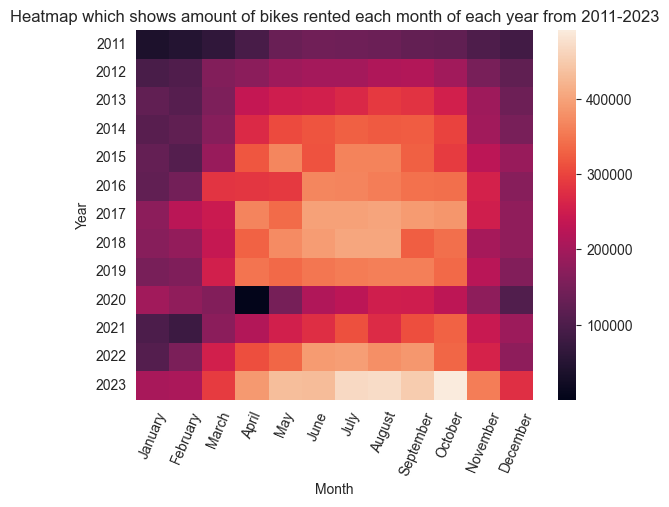

In [17]:
import seaborn as sns
import pandas as pd

years = [2010 + x for x in range(1, 14)]
months = [x for x in range(1, 13)]
years_df = []
months_df = []
for year in years:
    for month in months:
        years_df.append(year)
        months_df.append(month)

year_month_counts = [0 for x in range(len(years_df))]
df = pd.DataFrame({'year': years_df, 'month': months_df, 'count': year_month_counts}, dtype=int)

for idx, row in bikesRentedPerHourCombinedData.iterrows():
    row_year = row['datetime'].year
    if row_year in years:
        row_month = row['datetime'].month
        df.loc[(df['year'] == row_year) & (df['month'] == row_month), 'count'] += row['count']

year_counts = []
for year in years:
    month_counts = []
    for month in months:
        month_counts.append(df.loc[(df['year'] == year) & (df['month'] == month), 'count'].values[0])
    year_counts.append(month_counts)

heatmap = sns.heatmap(year_counts, vmin=500)
heatmap.set(xlabel='Month', ylabel='Year')
heatmap.set_xticklabels(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
     'December'], rotation=67)
heatmap.set_yticklabels(years, rotation=0)
heatmap.set_title("Heatmap which shows amount of bikes rented each month of each year from 2011-2023")
heatmap


<Axes: title={'center': 'Bike sharing amount over time'}, xlabel='Date', ylabel='Count'>

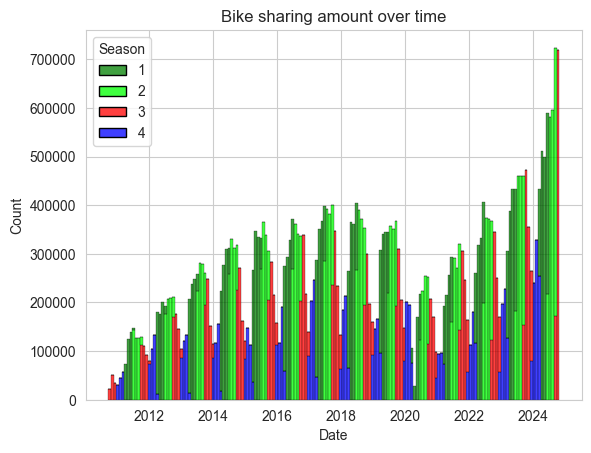

In [42]:
palette = {1: "green", 2: "lime", 3: "red", 4: "blue"}

# Since the seaborn histogram makes a heatmap when giving an x and y value at the same time, we have to do some fairly meaningless work by multiplying datetimes by count
# Takes a fairly long time, manually dividing into bins would likely be faster
datetimes_final = []
seasons_final = []
for idx, row in bikesRentedPerHourCombinedData.iterrows():
    datetimes = [row['datetime'] for x in range(row['count'])]
    datetimes_final += datetimes
    seasons = [row['season'] for x in range(row['count'])]
    seasons_final += seasons

df = pd.DataFrame({"datetime": datetimes_final, "season": seasons_final})
df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

histogram = sns.histplot(data=df, x='datetime', bins=170, hue="season", palette=palette, legend=True, multiple="stack",
                         stat="count", edgecolor="black")
sns.move_legend(histogram, "upper left", title="Season")
histogram.set(xlabel='Date', ylabel='Count', title="Bike sharing amount over time")
histogram.figure.savefig("over_time_bike_rental_with_seasons_histogram.png")
histogram


<Axes: title={'center': 'Bike sharing amount over time'}, xlabel='Date', ylabel='Count'>

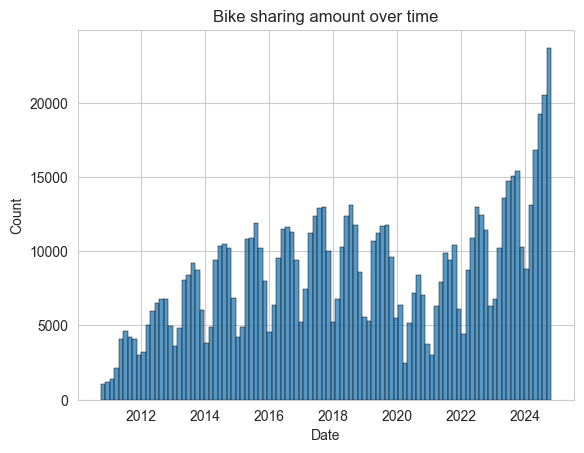

In [43]:
histogram = sns.histplot(data=df, x='datetime', bins=100, edgecolor="black", stat="frequency")
histogram.set(xlabel='Date', ylabel='Count', title="Bike sharing amount over time")
histogram.figure.savefig("over_time_bike_rental_histogram.png")
histogram

## Rental demand by season

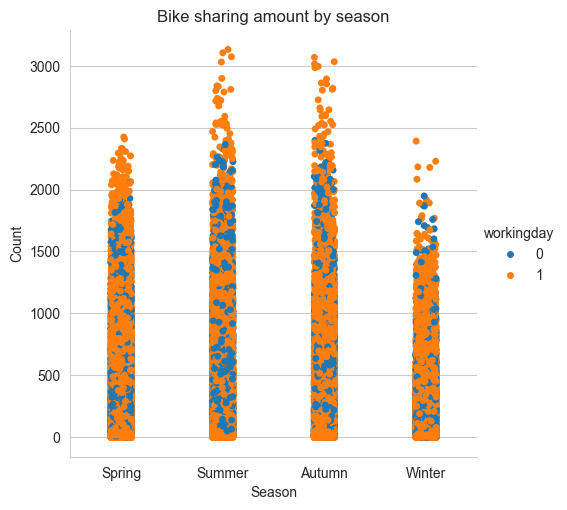

In [44]:
import seaborn as sns

categorical_plot = sns.catplot(data=bikesRentedPerHourCombinedData, x='season', y='count',
                               hue='workingday')  #, size=5, aspect=1.5)
categorical_plot.set(title='Bike sharing amount by season', xticks=[0, 1, 2, 3],
                     xticklabels=["Spring", "Summer", "Autumn", "Winter"], xlabel='Season', ylabel='Count')
categorical_plot.fig.savefig("seasonal_bike_rental_strip_plot.png")
categorical_plot

## Rental demand by day

2024-12-08 is 6


<Axes: title={'center': 'Bike sharing averages by day (y starts at 7500)'}, xlabel='Day of the week', ylabel='Count'>

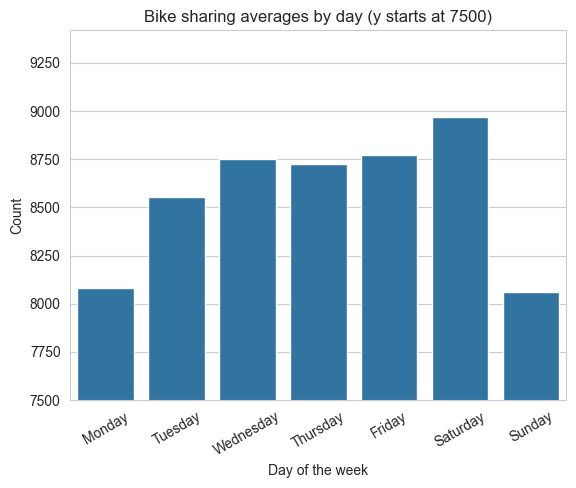

In [46]:
import seaborn as sns
from datetime import date

bikesRentedPerHourCombinedData["day"] = [t.dayofweek for t in pd.DatetimeIndex(bikesRentedPerHourCombinedData.datetime)]

# Getting daily averages
daily_means = [0, 0, 0, 0, 0, 0, 0]
daily_means[0] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 0]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 0]) / 24)
daily_means[1] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 1]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 1]) / 24)
daily_means[2] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 2]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 2]) / 24)
daily_means[3] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 3]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 3]) / 24)
daily_means[4] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 4]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 4]) / 24)
daily_means[5] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 5]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 5]) / 24)
daily_means[6] = bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 6]["count"].sum() / (
            len(bikesRentedPerHourCombinedData[bikesRentedPerHourCombinedData["day"] == 6]) / 24)

daily_means_df = pd.DataFrame({"day": [0, 1, 2, 3, 4, 5, 6], "mean": daily_means})
day_of_week_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

categorical_plot = sns.barplot(data=daily_means_df, x="day", y='mean')
categorical_plot.set(ylim=(7500, None), title='Bike sharing averages by day (y starts at 7500)', ylabel='Count',
                     xlabel='Day of the week',
                     xticks=[0, 1, 2, 3, 4, 5, 6])
categorical_plot.set_xticklabels(day_of_week_labels, rotation=30)

print(date.today(), "is", pd.to_datetime(date.today()).dayofweek)
categorical_plot.figure.savefig("daily_bike_rental_barplot.png")
categorical_plot

This plot is quite counterintuitive. One would imagine that Monday through Tuesday would have the highest values and the weekend would consist of lower values. This graph however shows that Monday and Saturday go by the opposite logic. This isn't a problem caused by differing regional weekday orders (like the week starting from Monday in the USA) as the `pandas` library `.dayofweek` function returns values starting from 0 which is a Monday ([API reference](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html)).

## Rental demand by hour

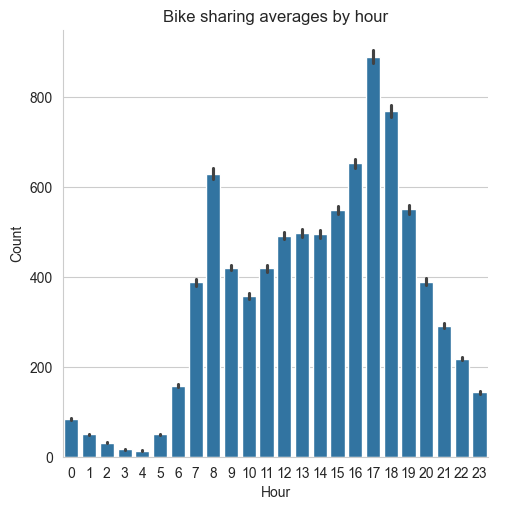

In [47]:
bikesRentedPerHourCombinedData["hour"] = [t.hour for t in pd.DatetimeIndex(bikesRentedPerHourCombinedData.datetime)]

categorical_plot = sns.catplot(x="hour", y="count", data=bikesRentedPerHourCombinedData, kind='bar')
categorical_plot.fig.savefig("hourly_bike_rental_barplot.png")
categorical_plot.set(xlabel='Hour', ylabel='Count', title='Bike sharing averages by hour')

## Rental demand by month

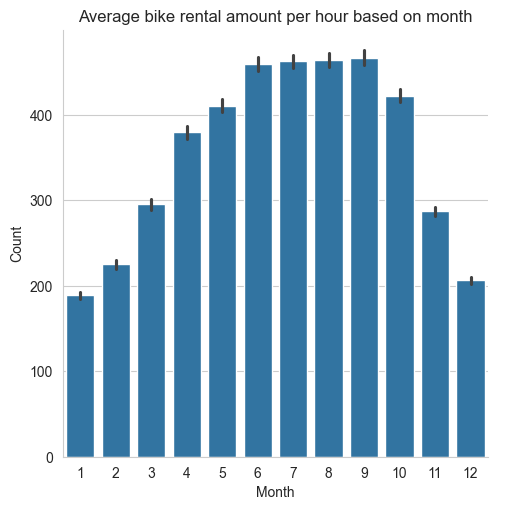

In [48]:
bikesRentedPerHourCombinedData["month"] = [t.month for t in pd.DatetimeIndex(bikesRentedPerHourCombinedData.datetime)]

categorical_plot = sns.catplot(x="month", y="count", data=bikesRentedPerHourCombinedData, kind='bar')
categorical_plot.fig.savefig("monthly_bike_rental_barplot.png")
categorical_plot.set(xlabel='Month', ylabel='Count', title='Average bike rental amount per hour based on month')

## Rental demand by temperature

count    123733.000000
mean         14.231232
std           9.954454
min         -21.400000
25%           6.200000
50%          14.800000
75%          22.400000
max          41.200000
Name: temp, dtype: float64


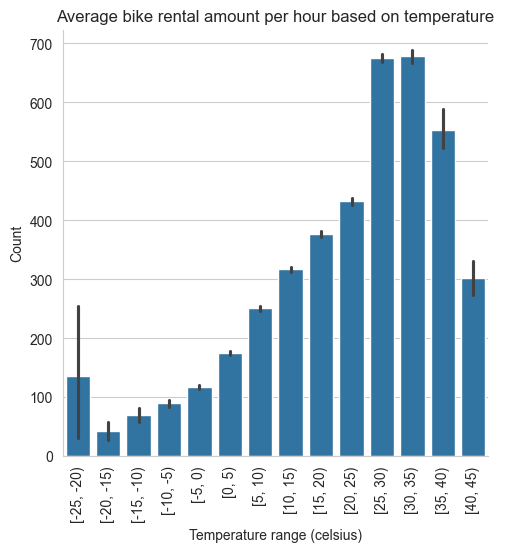

In [49]:
import numpy as np

# We'll need to divide temperatures into bins

print(bikesRentedPerHourCombinedData.temp.describe())
# Minimum is -21, max is 41

temp_bins = []
for idx, row in bikesRentedPerHourCombinedData.iterrows():
    temperature = row['temp']
    if temperature < -20:
        temp_bins.append(0)
    elif temperature < -15:
        temp_bins.append(1)
    elif temperature < -10:
        temp_bins.append(2)
    elif temperature < -5:
        temp_bins.append(3)
    elif temperature < 0:
        temp_bins.append(4)
    elif temperature < 5:
        temp_bins.append(5)
    elif temperature < 10:
        temp_bins.append(6)
    elif temperature < 15:
        temp_bins.append(7)
    elif temperature < 20:
        temp_bins.append(8)
    elif temperature < 25:
        temp_bins.append(9)
    elif temperature < 30:
        temp_bins.append(10)
    elif temperature < 35:
        temp_bins.append(11)
    elif temperature < 40:
        temp_bins.append(12)
    else:
        temp_bins.append(13)

bikesRentedPerHourCombinedData['temp_bin'] = temp_bins

categorical_plot = sns.catplot(data=bikesRentedPerHourCombinedData, x="temp_bin", y="count", kind='bar')
xticklabels = []
for x in range(0, 14):
    start_temp = x * 5 - 25
    end_temp = (x + 1) * 5 - 25
    xticklabels.append("[" + str(start_temp) + ", " + str(end_temp) + ")")

categorical_plot.set(xlabel='Temperature range (celsius)', ylabel='Count', title='Average bike rental amount per hour based on temperature',
                     xticks=range(0, 14))
categorical_plot.set_xticklabels(xticklabels, rotation=90)

categorical_plot.fig.savefig("temperature_bike_rental_barplot.png")
categorical_plot

## Rental demand by apparent temperature

Apparent temperature, also known as "feels like", is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed.

count    123733.000000
mean         13.096897
std          12.636480
min         -27.200000
25%           2.500000
50%          13.200000
75%          24.000000
max          46.100000
Name: atemp, dtype: float64


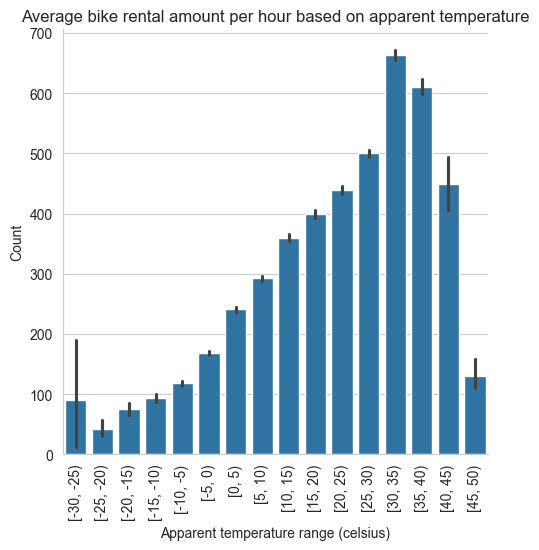

In [50]:
import numpy as np

# We'll need to divide temperatures into bins

print(bikesRentedPerHourCombinedData.atemp.describe())
# Minimum is -27, max is 46

atemp_bins = []
for idx, row in bikesRentedPerHourCombinedData.iterrows():
    apparent_temperature = row['atemp']
    if apparent_temperature < -25:
        atemp_bins.append(0)
    elif apparent_temperature < -20:
        atemp_bins.append(1)
    elif apparent_temperature < -15:
        atemp_bins.append(2)
    elif apparent_temperature < -10:
        atemp_bins.append(3)
    elif apparent_temperature < -5:
        atemp_bins.append(4)
    elif apparent_temperature < 0:
        atemp_bins.append(5)
    elif apparent_temperature < 5:
        atemp_bins.append(6)
    elif apparent_temperature < 10:
        atemp_bins.append(7)
    elif apparent_temperature < 15:
        atemp_bins.append(8)
    elif apparent_temperature < 20:
        atemp_bins.append(9)
    elif apparent_temperature < 25:
        atemp_bins.append(10)
    elif apparent_temperature < 30:
        atemp_bins.append(11)
    elif apparent_temperature < 35:
        atemp_bins.append(12)
    elif apparent_temperature < 40:
        atemp_bins.append(13)
    elif apparent_temperature < 45:
        atemp_bins.append(14)
    else:
        atemp_bins.append(15)

bikesRentedPerHourCombinedData['atemp_bin'] = atemp_bins

categorical_plot = sns.catplot(data=bikesRentedPerHourCombinedData, x="atemp_bin", y="count", kind='bar')
xticklabels = []
for x in range(0, 16):
    start_temp = x * 5 - 30
    end_temp = (x + 1) * 5 - 30
    xticklabels.append("[" + str(start_temp) + ", " + str(end_temp) + ")")

categorical_plot.set(xlabel='Apparent temperature range (celsius)', ylabel='Count', title='Average bike rental amount per hour based on apparent temperature',
                     xticks=range(0, 16))
categorical_plot.set_xticklabels(xticklabels, rotation=90)

categorical_plot.fig.savefig("apparent_temperature_bike_rental_barplot.png")
categorical_plot